<center><img src="img/skillfactorylogo.png"></center>

<h1><center>Курс "Практический Machine Learning"</center></h1>
<h3><center>Шестаков Андрей</center></h3>
<hr>
<h2><center>Композиции алгоритмов</center></h2>

aka 
* Ансамбли моделей
* Комитеты алгоритмов

In [11]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider
import pandas as pd
import scipy
from IPython.display import YouTubeVideo

Довольно популярный подход на соревнованиях (и все чаще - в реальных приложениях) смысл которого заключается в объединении предсказаний нескольких разных моделей.

## Пример из идеального мира:

* Пусть решается задача бинарной классификации
* Пусть у нас есть $M$ независимых *базовых* моделей, которые выдают верное предсказание с вероятностью $p \in (1/2, 1]$
* Финальный ответ определяется простым большинством
* Оказывается, что чем больше классификаторов в ансамбле - тем больше вероятность угадать ответ

In [12]:
M = 100
#T = M/2 + 1
T = int(M/2 + 1)
p = 0.6
p_ens = sum([scipy.special.comb(M,k)*(p**k)*((1-p)**(M-k)) for k in range(T, M+1)])
p_ens

0.972900802242991

Понятное дело, что на практике допольно сложно совместить идеальную независимость моделей и преемлемое качество, но мы можем постараться:

* Строить **базовые** модели на разных признаках
* Строить **базовые** модели на *немного разных* выборках

## Bagging и Случайный лес (Random Forest)

Дерево решений очень чувствительно к данным

In [13]:
from sklearn.datasets import make_moons

def demo_2dec_tree():
    fig, ax = plt.subplots(1,2)
    fig.set_figheight(5)

    np.random.seed(0)
    
    X, y = make_moons(noise=0.3, random_state=42)
    
    # Dec Tree Stuff
    for i in range(2):
        idx = np.random.randint(0, X.shape[0], int(0.95*X.shape[0]))

        X1 = X[idx, :]
        y1 = y[idx]

        ax[i].scatter(X1[:,0], X1[:, 1], c=y1)
        ax[i].set_xlabel('$x_1$')
        ax[i].set_ylabel('$x_2$')

        # Dec Tree Stuff 2
        tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=123)
        tree.fit(X1,y1)

        x_range = np.linspace(X.min(), X.max(), 100)
        xx1, xx2 = np.meshgrid(x_range, x_range)

        Y = tree.predict(np.c_[xx1.ravel(), xx2.ravel()])
        Y = Y.reshape(xx1.shape)

        ax[i].contourf(xx1, xx2, Y, alpha=0.3)
        ax[i].scatter(X[:,0], X[:,1],c=y)

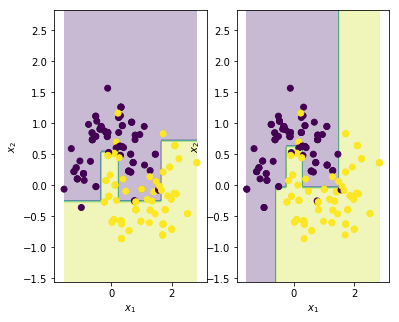

In [14]:
demo_2dec_tree()

Bagging - это **параллельный** способ построения ансамбля.<br/>
1. Обучающая выборка сэмплируется $k$ раз с помощью *bootstrap'a* (выборка с возвратом)
2. На каждом сэмпле обучается отдельная **базовая модель**
3. Ответы моделей усредняются (возможно с весом)
<center><img src='http://image.slidesharecdn.com/ipbimprovingthemodelspredictivepowerwithensembleapproaches-121203224610-phpapp02/95/improving-the-models-predictive-power-with-ensemble-approaches-10-638.jpg?cb=1354575467' width='750'></center>

Так же есть некоторые обобщения бэггинга:

* Метод случайных подпространств - на шаге 1. сэмплируются не только объекты, но и подпространство признаков
* Метод случайного леса - на каждом узле сэмплируется подпространство признаков

В данном случае, на каждом сэмпле базовой моделью является дерево решений.<br/>
Если вам нужно за минимальное время построить достаточно точную и устойчивую модель - это ваш вариант.


<center><img src='img/rf-quote.png'></center>

In [15]:
from sklearn.ensemble import RandomForestClassifier

def rf_demo(n_est=5):
    rf = RandomForestClassifier(random_state=123, n_estimators=n_est)

    np.random.seed(0)
    
    X, y = make_moons(noise=0.3, random_state=123)
    rf.fit(X, y)
    
    x_range = np.linspace(X.min(), X.max(), 100)
    xx1, xx2 = np.meshgrid(x_range, x_range)
    
    
    for tree in rf.estimators_:
        y_hat = tree.predict(np.c_[xx1.ravel(), xx2.ravel()])
        y_hat = y_hat.reshape(xx1.shape)

        plt.contourf(xx1, xx2, y_hat, alpha=1.0/n_est)
    plt.scatter(X[:,0], X[:,1], c=y)
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.title('N estimators = %d' % n_est)
    plt.show()


In [16]:
fig = interact(rf_demo, n_est=IntSlider(min=1, max=101, value=1, step=5))

interactive(children=(IntSlider(value=1, description='n_est', max=101, min=1, step=5), Output()), _dom_classes…

## Данные об оттоке из игры

In [17]:
dfx = pd.read_csv('data/x_train.csv', sep=';')
dfy = pd.read_csv('data/y_train.csv', names=['target'])


In [18]:
X = dfx.values
y = dfy.values.flatten()

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

### Качество на одном дереве

In [20]:
cv = StratifiedKFold(n_splits=4, random_state=123)
scoring = 'roc_auc'

In [21]:
model = DecisionTreeClassifier()

In [22]:
depths = range(1, 10)
_, tree_test_scores = validation_curve(model, X, y, param_name='max_depth', param_range=depths, 
                 scoring=scoring, cv=cv, n_jobs=-1)

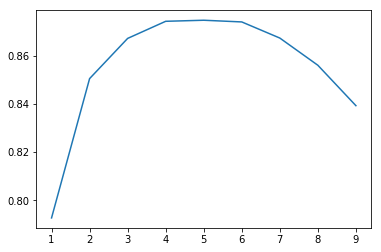

In [23]:
plt.plot(depths, tree_test_scores.mean(axis=1))

### Бэггинг над деревьями

In [24]:
from sklearn.ensemble import BaggingClassifier

In [25]:
model = BaggingClassifier(DecisionTreeClassifier(), n_estimators=50, random_state=123)

In [26]:
_, bag_test_scores = validation_curve(model, X, y, param_name='base_estimator__max_depth', param_range=depths, 
                 scoring=scoring, cv=cv, n_jobs=-1)

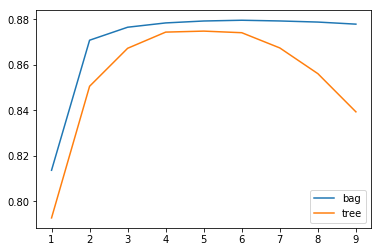

In [27]:
plt.plot(depths, bag_test_scores.mean(axis=1), label='bag')
plt.plot(depths, tree_test_scores.mean(axis=1), label='tree')
plt.legend()

### Случайных лес

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
model = RandomForestClassifier(random_state=123, n_estimators=50, n_jobs=-1)

In [30]:
_, forest_test_scores = validation_curve(model, X, y, param_name='max_depth', param_range=depths, 
                 scoring=scoring, cv=cv, n_jobs=1)

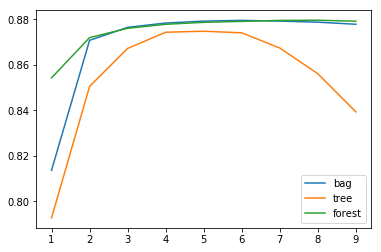

In [31]:
plt.plot(depths, bag_test_scores.mean(axis=1), label='bag')
plt.plot(depths, tree_test_scores.mean(axis=1), label='tree')
plt.plot(depths, forest_test_scores.mean(axis=1), label='forest')
plt.legend()

## Разные фишки

### Бэггинг можно делать не только над деревьями

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [33]:
cv = StratifiedKFold(n_splits=4, random_state=123)
scoring = 'roc_auc'

In [34]:
scores = []
n_est =  [1, 10, 20, 50, 100]

for n in n_est:
    model = BaggingClassifier(base_estimator=LogisticRegression(), 
                              n_estimators=n, 
                              bootstrap_features=False, n_jobs=1)
    scores.append(cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=1).mean())

In [35]:
scores

[0.7425924003377005,
 0.7424200530751672,
 0.7441050862475873,
 0.7444644619838786,
 0.7445019920970524]

### Листья деревьев как признаки!

Перед тем как применять линейную модель, можно собрать специальные признаки на основе деревьев.

* Предварительно на данных строим лес из $T$ деревьем
* Нумеруем листья каждого дерева от $0$ до $L_T$
* Для каждого дерева собираем новый признак "номер листа в котором оказался объект"
* Прогоняем новые признаки через OHE 
* Profit?

Можно строить такое признаковое пространство с помощью случайного леса, но надо быть осторожным!

Можно строить случайные деревья!

In [36]:
from sklearn.ensemble import RandomTreesEmbedding

In [37]:
emb = RandomTreesEmbedding(n_estimators=10, max_depth=5, random_state=123)
emb.fit(X)

# emb = RandomForestClassifier(n_estimators=10, max_depth=5, random_state=123)
# emb.fit(X, y)

RandomTreesEmbedding(max_depth=5, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           random_state=123, sparse_output=True, verbose=0,
           warm_start=False)

In [38]:
X_emb = emb.apply(X)

In [39]:
X_emb[:10]

array([[15, 15, 12, 31,  5,  5,  6,  5, 15, 18],
       [23, 15, 15, 31,  5, 23,  6,  5, 15, 39],
       [15,  5,  9, 31,  8,  5,  5, 41,  8,  6],
       [ 8,  5, 12,  5,  5,  5,  5,  5,  5,  5],
       [15,  5,  8, 31,  8,  5,  5, 41,  8,  6],
       [ 5,  5,  5, 12,  5,  5,  5,  5,  5,  5],
       [15,  5, 12, 31,  9,  5,  6,  5,  8, 18],
       [15,  5, 12, 31,  5,  5,  6,  5,  5, 18],
       [ 8,  5,  5, 30,  5,  5,  5,  5,  5,  5],
       [ 5, 12,  6, 30,  5,  5,  5,  5, 12,  5]])

In [40]:
X_emb_sparse = emb.transform(X)

In [41]:
X_emb_sparse

<25289x224 sparse matrix of type '<class 'numpy.float64'>'
	with 252890 stored elements in Compressed Sparse Row format>

In [42]:
model = Pipeline([
    ('tree_emb', RandomTreesEmbedding(n_estimators=50, max_depth=4)),
    ('clf', LogisticRegression(C=0.1))
])

simple_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(C=0.1))
])


In [43]:
scores = cross_val_score(model, X, y, scoring=scoring, cv=cv)
scores.mean()

0.8771678976780891

In [44]:
scores = cross_val_score(simple_model, X, y, scoring=scoring, cv=cv)
scores.mean()

0.8734718403431592

## Бустинг

Boosting, в отличие от bagging'а - это **последовательный** способ построения композиции моделей.

Мы постоянно работаем с одним и тем же набором данных, **но** на каждом шаге строим новую базовую модель, которая учитывает ошибки предыдущей модели.<br\>По большому счету, бустинг-алгоритмы отличаются лишь тем, как в них заложен учет этих самых ошибок.

Например в методе **AdaBoost** каждому объекту присваивается вес, который изменяется в зависимости от того, ошиблась ли на нем очередная композиция базовых алгоритмов или нет. Так же веса имеются и у самих базовых моделей, которые штрафуют их за плохие предсказания. Для задачи классификации этот процесс можно проиллюстрировать следующим образом:


<center><img src='img/adaboost.png' width='650'></center>

### Формальное описание алгоритма AdaBoost

#### Обозначения
Введем следующие обозначения:
* $t_k$ - базовый классификатор, полученный на шаге $k$
* $\alpha_k$ - вес базового классификатора, полученного на шаге $k$
* $w_k(i)$ - веса объектов на шаге $k$
* $x_i$ - $i$-й объект, $i = 1, \dots, N$
* $y_i=\{-1, 1\}$ - метки класса для $i$-го объекта 

#### Конечное предсказание
Конечное предсказание получается из взвешенной комбинации предсказания базовых моделей:
$$ T(x^*) = sign(\sum\limits^{K}_{k=1}\alpha_kt_k(x^*)) $$

Наша цель - минимизировать количество ошибок на всей выборке ..

$$ E_T = \frac{1}{N}\sum\limits_{i=1}^N [T(x_i) \neq y_i] $$

.. которые мы мажорируем экспонентой =)

$$ E_T = \frac{1}{N}\sum\limits_{i=1}^N [T(x_i) \neq y_i] \leq \frac{1}{N}\sum\limits_{i=1}^N e^{(-y_i\sum_k\alpha_kt_k(x_i))} $$

Если мы посчитаем ошибки $E_1, E_2, E_3,...$ на каждом шаге, то это даст нам правило для обновления весов объектов. <br\>
А если мы посчитаем производную ошибки $E_t$ по $\alpha_t$, то это даст нам правило для обновления весов базовых моделей. <br\>

#### Алгоритм
Алгоритм обучения **Discrete AdaBoost**:

* Инициализируем веса объектов $w_1(i) = \frac{1}{N}$ 
* Для $k = 1..K$
    * Обучить классификатор $t_k(x) \in \{-1, 1\}$ используя веса объектов $w(i)_k$
    * Вычислить взвешенную ошибку $\epsilon = \frac{\sum_i w_{k}(i)[y_i \neq t_k(x_i) ]}{\sum_i w_{k}(i)}$
    * Вычислить вес базовой модели $\alpha_k = \ln\frac{1-\epsilon}{\epsilon}$
    * Пересчитать веса объектов $w_{k+1}(i) = \frac{w_{k}(i) e^{-\alpha_k y_i t_k(x_i)}}{W}$, $i = 1, \dots, N$,где $W = \sum_i w_k(i) e^{-\alpha_k y_i t_k(x_i)}$ - нормировочная константа.
* $T(x) = sign(\sum_k \alpha_k t_k(x))$

### Демо

In [45]:
from sklearn.datasets import make_moons
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier


def ada_demo(n_est=1):

    ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1,), n_estimators=n_est, learning_rate=0.1)
    ada.fit(X_moons, y_moons)
    

    plt.figure(figsize=(7,5))

    xx1, xx2 = np.meshgrid(np.arange(-1.5, 2.5, 0.1),
                           np.arange(-1, 1.5, 0.1))

    y_hat = ada.predict(np.c_[xx1.ravel(), xx2.ravel()])
    
    y_hat = y_hat.reshape(xx1.shape)

    plt.title('iteration = %d' % n_est )
    plt.contourf(xx1, xx2, y_hat, cmap=plt.cm.Paired)
    plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)
    
    plt.show()

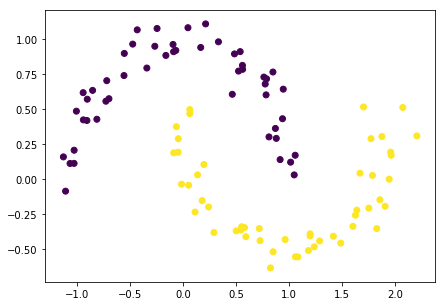

In [46]:
X_moons, y_moons = make_moons(noise=0.1)
plt.figure(figsize=(7,5))
plt.scatter(X_moons[:, 0], X_moons[:, 1], c=y_moons)

In [47]:
interact(ada_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))

interactive(children=(IntSlider(value=1, description='n_est', max=150, min=1), Output()), _dom_classes=('widge…

<function __main__.ada_demo(n_est=1)>

### Применим на наших данных

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [49]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=123, test_size=0.2)

In [50]:
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), 
                         algorithm='SAMME',
                         n_estimators=100,
                         learning_rate=1., 
                         random_state=123)

In [51]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1.0, n_estimators=100, random_state=123)

По некоторым математическим соображениям, веса базовых моделей в `SAMME.R` равны `1.` и learning rate учитывается в весах объектов (см. [тут](https://stackoverflow.com/questions/31981453/why-estimator-weight-in-samme-r-adaboost-algorithm-is-set-to-1)

In [52]:
scores_train = []
scores_valid = []

for y_pred in ada.staged_predict_proba(X_train):
    scores_train.append(roc_auc_score(y_train, y_pred[:, 1]))
    
for y_pred in ada.staged_predict_proba(X_valid):
    scores_valid.append(roc_auc_score(y_valid, y_pred[:, 1]))

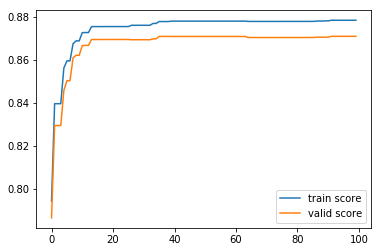

In [53]:
plt.plot(scores_train, label='train score')
plt.plot(scores_valid, label='valid score')
plt.legend()

In [54]:
scores = cross_val_score(ada, X, y, scoring=scoring, cv=cv, n_jobs=-1)
scores.mean()

0.8765660565828375

## Градиентный бустинг


По своей структуре метод похож на алгоритм градиентного спуска - отсюда и такое название.

<center><img src='img/golf-MSE.png' width=600></center>

<center><img src='img/golf-table.svg' width=700></center>

Больше - [здесь](http://explained.ai/gradient-boosting/index.html)

* [Превью Градиентного Бустинга](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)


### Немного формальности

Пусть дана дифференцируемая функция потерь $L(T_k(x), y)$ (для любой задачи - регрессии или классификации) <br\>
Функционал качества - $Q(T, y) = \sum_iL(T_k(x_i), y_i) = \sum_iL(T_{k-1}(x_i) + t_{k}(x_i), y_i)$


На секунду представим, что $t_{k}(x_i)$ - это просто вектор значений (значение для каждого объекта). 

Надо "сдвинуть" ответы предыдущей композиции $T_{k-1}$, так чтобы минимизировать функцию потерь (как в градиентном спуске)

Тогда задачу оптимизации $Q(T, y)$ можно решать простым градиентным методом:

* $T_0$ - начальное приближение
* Посчитаем градиент функции потерь $L$: $g_i = \frac{\partial L(T_{k-1}(x_i), y_i)}{\partial T_{k-1}(x_i)}$, $i = 1, \dots, N$ 
* $T_k = T_{k-1} - \alpha g$ - делаем градиентный шаг


Тогда $t_{k}(x) =  \arg\min\limits_{t} \sum\limits_i(t_{k}(x_i) - g_i)^2$, не зависимо от функции потерь.

### Демо

In [55]:
from sklearn.ensemble import GradientBoostingRegressor

def grad_demo(n_est=1):
    
    np.random.seed(123)
    X = np.random.uniform(-10, 10, 500)

    y = np.sin(X)/X + np.random.normal(0, .1, 500)
    plt.scatter(X, y)
    

    gbr = GradientBoostingRegressor(n_estimators=n_est, learning_rate=0.15)
    gbr_full = GradientBoostingRegressor(n_estimators=200, learning_rate=0.15)
    gbr.fit(X.reshape(-1,1), y)
    gbr_full.fit(X.reshape(-1,1), y)
    
    x_range = np.linspace(X.min(), X.max(), 100).reshape((-1,1))

    for y_hat in gbr.staged_predict(x_range):
        plt.plot(x_range, y_hat, alpha=0.4, c='g')

    y_hat = gbr_full.predict(x_range)
    
    plt.title('Estimators %d' % n_est)
    plt.plot(x_range, y_hat, c='r')
    plt.xlabel('x')
    plt.xlabel('y')
    plt.ylim((-0.5, 1.3))
    plt.xlim(-11,11)
    
    plt.show()

In [56]:
interact(grad_demo, n_est=IntSlider(min=1, max=150, value=1, step=1))

interactive(children=(IntSlider(value=1, description='n_est', max=150, min=1), Output()), _dom_classes=('widge…

<function __main__.grad_demo(n_est=1)>

#### Особенности
* Последовательное обучение
* Склонность к переобучению
* Проблемы с интерпретацией

Наибольший успех, а потому и популярность, получил градиентный бустинг на деревьях решений.

На досуге обратите внимание на модель `xgboost`. Вводный курс по этой модели можно найти [тут](http://education.parrotprediction.teachable.com/p/practical-xgboost-in-python)

Так же есть другая популярная реализация бустинга [LightGBM](https://github.com/Microsoft/LightGBM)

И, конечно же, недавний [CatBoost](https://tech.yandex.ru/catboost/), [видео](https://youtu.be/Q_xa4RvnDcY)

In [57]:
from sklearn.ensemble import GradientBoostingClassifier

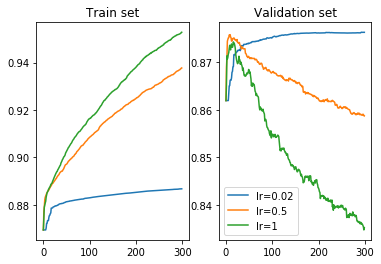

In [58]:
fig, ax = plt.subplots(1,2)

for lr in [0.02, 0.5, 1]:

    model = GradientBoostingClassifier(n_estimators=300, max_depth=3,
                                       learning_rate=lr, 
                                       random_state=123)
    model.fit(X_train, y_train)

    scores_train = []
    scores_valid = []

    for y_pred in model.staged_predict_proba(X_train):
        scores_train.append(roc_auc_score(y_train, y_pred[:, 1]))
        
    ax[0].plot(scores_train, label='lr={}'.format(lr))
    ax[0].set_title('Train set')

    for y_pred in model.staged_predict_proba(X_valid):
        scores_valid.append(roc_auc_score(y_valid, y_pred[:, 1])) 
        
    ax[1].plot(scores_valid, label='lr={}'.format(lr))
    ax[1].set_title('Validation set')
plt.legend()


In [59]:
model = GradientBoostingClassifier(n_estimators=300, max_depth=3,
                                       learning_rate=0.02, 
                                       random_state=123)

In [60]:
scores = cross_val_score(model, X, y, scoring=scoring, cv=cv, n_jobs=-1)
scores.mean()

0.8799075604995585

In [61]:
model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=123, subsample=1.0, verbose=0,
              warm_start=False)

In [62]:
imp = pd.Series(index=dfx.columns, data=model.feature_importances_)

In [63]:
imp

maxPlayerLevel                        0.109797
numberOfAttemptedLevels               0.003750
attemptsOnTheHighestLevel             0.048529
totalNumOfAttempts                    0.253958
averageNumOfTurnsPerCompletedLevel    0.110087
doReturnOnLowerLevels                 0.003267
numberOfBoostersUsed                  0.066444
fractionOfUsefullBoosters             0.028718
totalScore                            0.066346
totalBonusScore                       0.021913
totalStarsCount                       0.011624
numberOfDaysActuallyPlayed            0.275568
dtype: float64

### Попытка интерпретации - partial dependency plot

In [64]:
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence

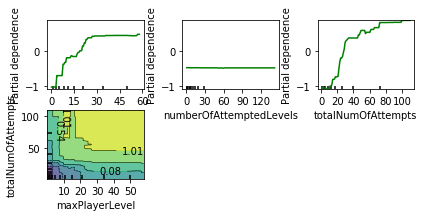

In [65]:
fig, ax =\
plot_partial_dependence(model, X_train, [0, 1, 3, (0,3)], 
                        feature_names=dfx.columns)

In [66]:
pdp, axes = partial_dependence(model, [0], X=X_train, )

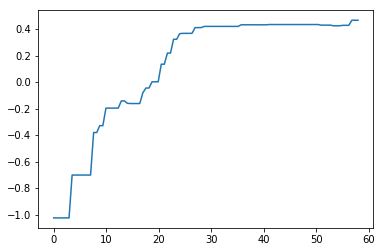

In [67]:
plt.plot(axes[0], pdp[0])

# Стэкинг и Блендинг

Схемы бэггинга и бустинка не гибкие. По сути, на каждом этапе обучается один и тот же алгоритм на немного измененных данных.

Можно еще собирать ансамбли **разных моделей** и аггрегировать их результаты. Только не переобучиться бы..

### Схема классического блендинга
<center><img src='https://alexanderdyakonov.files.wordpress.com/2017/03/stacking.png?w=700'></center>

### Схема классического стекинга
<center><img src='https://alexanderdyakonov.files.wordpress.com/2017/03/stacking-2b.png?w=700'></center>

### Стэкинг франкенштейн

<img src='https://kaggle2.blob.core.windows.net/forum-message-attachments/79598/2514/FINAL_ARCHITECTURE.png'>

In [68]:
#!pip install vecstack

In [69]:
from vecstack import stacking

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [71]:
models = [
    RandomForestClassifier(n_estimators=50, max_depth=5, random_state=123),
    RandomForestClassifier(n_estimators=50, max_depth=10, random_state=123, max_features='log2'),
    Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression())
    ]),
    Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier(n_neighbors=11))
    ]),
    GaussianNB()
]

In [72]:
def roc_auc_score_cust(y_true, y_hat):
    return roc_auc_score(y_true, y_hat[:,1])

In [73]:
S_train, S_valid = stacking(models,
                               X_train, y_train, X_valid,
                               regression=False,
                               mode='oof_pred_bag', 
                               needs_proba=True,
                               metric=roc_auc_score_cust,
                               n_folds=5,                
                               stratified=True,          
                               shuffle=True,             
                               random_state=123,         
                               verbose=2)                

task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score_cust]
mode:         [oof_pred_bag]
n_models:     [5]

model  0:     [RandomForestClassifier]
    fold  0:  [0.88177273]
    fold  1:  [0.88243647]
    fold  2:  [0.88676255]
    fold  3:  [0.87102158]
    fold  4:  [0.87560107]
    ----
    MEAN:     [0.87951888] + [0.00554285]
    FULL:     [0.87920882]

model  1:     [RandomForestClassifier]
    fold  0:  [0.88206891]
    fold  1:  [0.88025162]
    fold  2:  [0.88633036]
    fold  3:  [0.87063865]
    fold  4:  [0.87612213]
    ----
    MEAN:     [0.87908234] + [0.00534564]
    FULL:     [0.87890000]

model  2:     [Pipeline]
    fold  0:  [0.87752342]
    fold  1:  [0.87690061]
    fold  2:  [0.88109657]
    fold  3:  [0.86698334]
    fold  4:  [0.86898332]
    ----
    MEAN:     [0.87429745] + [0.00538790]
    FULL:     [0.87421612]

model  3:     [Pipeline]
    fold  0:  [0.86252076]
    fold  1:  [0.85394339]
    fold  2:  [0.86405013]
    fold  3:  [0.

In [74]:
last_model = GradientBoostingClassifier(n_estimators=300, max_depth=3,
                                       learning_rate=0.01, 
                                       random_state=123)

In [75]:
last_model.fit(S_train, y_train)
y_hat = last_model.predict_proba(S_valid)
roc_auc_score(y_valid, y_hat[:, 1])

0.8749403333441643

In [76]:
for model in models:
    model.fit(X_train, y_train)
    y_hat = model.predict_proba(X_valid)
    score = roc_auc_score(y_valid, y_hat[:, 1])
    print('{}: {}'.format(model.__str__().split('(')[0], score))

RandomForestClassifier: 0.8746871610508449
RandomForestClassifier: 0.8747862831290163
Pipeline: 0.8689816942313079
Pipeline: 0.8457620814824098
GaussianNB: 0.799504853790583


## Идея для ансамблей с временными рядами

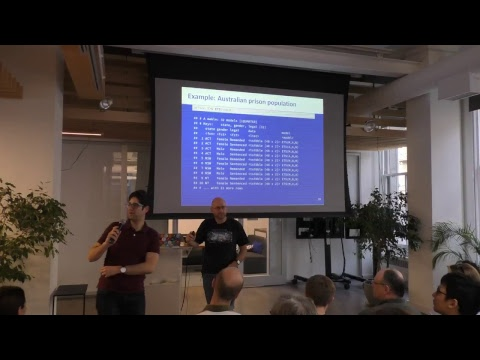

In [77]:
YouTubeVideo('yx6OQ-8HofU', )

## Полезные ссылки

* [Вводный курс по XGB](http://education.parrotprediction.teachable.com/p/practical-xgboost-in-python)
* [LightGBM](https://github.com/Microsoft/LightGBM)
* [CatBoost](https://tech.yandex.ru/catboost/)
* [Сравнение библиотек](https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db)
* [Kaggle про смешивание алгоритмов](http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/)
* [Пост про градиентный бустинг от А.Дьяконова](https://alexanderdyakonov.wordpress.com/2017/06/09/%d0%b3%d1%80%d0%b0%d0%b4%d0%b8%d0%b5%d0%bd%d1%82%d0%bd%d1%8b%d0%b9-%d0%b1%d1%83%d1%81%d1%82%d0%b8%d0%bd%d0%b3/)
* [Пост про стекинг и блендинг от А.Дьяконова](https://alexanderdyakonov.wordpress.com/2017/03/10/c%D1%82%D0%B5%D0%BA%D0%B8%D0%BD%D0%B3-stacking-%D0%B8-%D0%B1%D0%BB%D0%B5%D0%BD%D0%B4%D0%B8%D0%BD%D0%B3-blending/)
* [Еще одна библиотека на питоне для ансамблей](http://ml-ensemble.com/info/tutorials/start.html)